### Understanding the dataset features

As per the source from where the dataset was taken, the following assumptions have been taken into consideration:

- datetime: Hourly date + Timestamp  
- season: 
     -  1 = spring
     -  2 = summer
     -  3 = fall 
     -  4 = winter 
- holiday:
     - 0 = no holiday
     - 1 = holiday
- workingday:
     - 0 = neither a holiday nor weekend
     - 1 = holiday or weekend
- weather:

    - 1 = Clear, Few clouds, Partly cloudy, Partly cloudy 

    - 2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 

    - 3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 

    - 4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

- temp:  Temperature in Celsius
- atemp: "Feels like" temperature in Celsius
- humidity: relative humidity
- windspeed: wind speed
- casual: number of non-registered user rentals initiated
- registered: number of registered user rentals initiated
- count:  number of total rentals

In [1]:
# Loading the libraries

# Data Manipulation and Plots/Outputs
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random
random.seed(1)
import csv

import warnings
warnings.filterwarnings("ignore")

#Data Pre-processing
from sklearn.preprocessing import MinMaxScaler 

# Sklearn model selection libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

# Sklearn models
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

#Sklearn Feature Selection
from sklearn.feature_selection import SelectFromModel


#Keras Models
from keras.models import Sequential
from keras.layers import Dense


Using TensorFlow backend.


In [2]:
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes= True)

In [3]:
# Loading the Data
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')

# Viewing the training data
train_data.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data Pre-Processing

- Handling Missing Values : 
  From the exploratory data analysis,it was observed that there are no missing values in the given training set. The next      section checks the presence of missing values and gives details of the types of variables
- Converting Data to usable format :
  Splitting the datetime column to hour, day, month and year columns
- Handling Categorical Data :
  Using One-Hot Encoding as a part of data preparation
- Dropping Unnecessary Columns if any

In [4]:
# Handling Missing Values
print(train_data.isnull().sum())
print('\n \n')
print(train_data.columns)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

 

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


In [5]:
def quantile(x, p):
    """returns the pth-percentile value in x"""
    p_index = int(p * len(x))
    return sorted(x)[p_index]

In [6]:
#Removing Outliers
l_bound = quantile(train_data['count'],0.25) - 1.5*(quantile(train_data['count'],0.75)-quantile(train_data['count'],0.25))
u_bound = quantile(train_data['count'],0.75) + 1.5*(quantile(train_data['count'],0.75)-quantile(train_data['count'],0.25))

#Outliers removal for preprocessed train data
train_df_good = train_data.loc[(train_data['count']<=u_bound) & (train_data['count']>=l_bound)]



In [7]:
# Converting Data to usable format
#Doing for training data

train_df = train_df_good.copy()
train_df["hour"] = [i.hour for i in pd.DatetimeIndex(train_df_good.datetime)]
train_df["day"] = [i.dayofweek for i in pd.DatetimeIndex(train_df_good.datetime)]
train_df["month"] = [i.month for i in pd.DatetimeIndex(train_df_good.datetime)]
train_df['year'] = [i.year for i in pd.DatetimeIndex(train_df_good.datetime)]
train_df.drop('datetime',axis=1,inplace=True)
print(train_df.head())


#Doing for test data
test_df = test_data.copy()
test_df["hour"] = [i.hour for i in pd.DatetimeIndex(test_data.datetime)]
test_df["day"] = [i.dayofweek for i in pd.DatetimeIndex(test_data.datetime)]
test_df["month"] = [i.month for i in pd.DatetimeIndex(test_data.datetime)]
test_df['year'] = [i.year for i in pd.DatetimeIndex(test_data.datetime)]
test_df.drop('datetime',axis=1,inplace=True)
print(test_df.head())

   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   casual  registered  count  hour  day  month  year  
0       3          13     16     0    5      1  2011  
1       8          32     40     1    5      1  2011  
2       5          27     32     2    5      1  2011  
3       3          10     13     3    5      1  2011  
4       0           1      1     4    5      1  2011  
   season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       1        0           1        1  10.66  11.365        56    26.0027   
1       1        0           1        1  10

In [8]:
# One-Hot Encoding
encoded_data_dummy = train_df
def dummify_dataset(df, col):       
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col, drop_first=True)],axis=1)
    df = df.drop([col], axis=1)
    return df

columns_to_dummify = ['season', 'month', 'hour', 'holiday', 'day', 'workingday', 'weather','year']
for column in columns_to_dummify:
    encoded_data_dummy = dummify_dataset(encoded_data_dummy, column)
    
encoded_data_dummy.head(10)

,temp,atemp,humidity,windspeed,casual,registered,count,season_2,season_3,season_4,...,day_2,day_3,day_4,day_5,day_6,workingday_1,weather_2,weather_3,weather_4,year_2012
0,9.84,14.395,81,0.0000,3,13,16,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,9.02,13.635,80,0.0000,8,32,40,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,9.02,13.635,80,0.0000,5,27,32,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,9.84,14.395,75,0.0000,3,10,13,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,9.84,14.395,75,0.0000,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,9.84,12.880,75,6.0032,0,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
6,9.02,13.635,80,0.0000,2,0,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,8.20,12.880,86,0.0000,1,2,3,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,9.84,14.395,75,0.0000,1,7,8,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,13.12,17.425,76,0.0000,8,6,14,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
# Creating the feature and target dataframes
X_full = encoded_data_dummy.drop(['casual','registered'], axis = 1).astype('float64')
y = X_full['count']
X = X_full.drop(['count'], axis = 1).astype('float64')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10586 entries, 0 to 10885
Data columns (total 53 columns):
temp            10586 non-null float64
atemp           10586 non-null float64
humidity        10586 non-null float64
windspeed       10586 non-null float64
season_2        10586 non-null float64
season_3        10586 non-null float64
season_4        10586 non-null float64
month_2         10586 non-null float64
month_3         10586 non-null float64
month_4         10586 non-null float64
month_5         10586 non-null float64
month_6         10586 non-null float64
month_7         10586 non-null float64
month_8         10586 non-null float64
month_9         10586 non-null float64
month_10        10586 non-null float64
month_11        10586 non-null float64
month_12        10586 non-null float64
hour_1          10586 non-null float64
hour_2          10586 non-null float64
hour_3          10586 non-null float64
hour_4          10586 non-null float64
hour_5          10586 non-null fl

In [10]:
#Creating Training and Validation Tests
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)


In [11]:
scaler =  MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [12]:
#Feature Selection
clf = LassoCV(cv=3)

# Set a minimum threshold of 0.80
sfm = SelectFromModel(clf, threshold=0.60)
sfm.fit(X_train, y_train)
n_features = sfm.transform(X_test).shape[1]

# Extracting the index of important features
feature_idx = sfm.get_support()
pd.Series(feature_idx, index=X.columns)

temp             True
atemp            True
humidity         True
windspeed        True
season_2         True
season_3         True
season_4         True
month_2          True
month_3          True
month_4         False
month_5          True
month_6          True
month_7         False
month_8          True
month_9          True
month_10         True
month_11        False
month_12         True
hour_1           True
hour_2           True
hour_3           True
hour_4           True
hour_5           True
hour_6           True
hour_7           True
hour_8           True
hour_9           True
hour_10          True
hour_11          True
hour_12          True
hour_13          True
hour_14          True
hour_15          True
hour_16          True
hour_17          True
hour_18          True
hour_19          True
hour_20          True
hour_21          True
hour_22          True
hour_23          True
holiday_1       False
day_1            True
day_2            True
day_3            True
day_4     

In [13]:
# Removing the undesired features from the data

unimp_features = []
for i in range(len(feature_idx)):
    if not(feature_idx[i]):
        unimp_features.append(X.columns[i])

X_full= X_full.drop(unimp_features, axis = 1).astype('float64')


### Training and test split and scaling

In [14]:

X_train,X_val,y_train,y_val = train_test_split(X_full.drop('count',axis=1),X_full['count'],test_size=0.20,random_state=1)


In [15]:
scaler =  MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val  = scaler.transform(X_val)

features_no = X_train.shape[1]

In [16]:
type(X_train)
#features_no

numpy.ndarray

In [17]:
from keras import backend as K
def Rsquare(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred )) 

    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 

    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [18]:
def ANN_model(features_no):
   
    seq = Sequential()
    seq.add(Dense(input_dim = features_no, output_dim = features_no, init = 'uniform', activation = 'relu'))
    seq.add(Dense(output_dim = int(features_no * 0.67), init = 'uniform', activation = 'relu' ))
    seq.add(Dense(output_dim = 1 , init = 'uniform', activation = 'linear'))
    seq.compile(optimizer = 'adam', loss = 'mse' , metrics = [Rsquare, 'mae', 'mse'] )
    
    return seq


### Benchmark Model
Taking Linear Regression Model to be the benchmark model. The aim is to further create models to outperform this benchmark model.

In [19]:
benchmark_model = LinearRegression()
benchmark_model.fit(X_train, y_train) 
y_res = benchmark_model.predict(X_val)
b_mse = mean_squared_error(y_val, y_res)
b_mae = mean_absolute_error(y_val, y_res)
b_score = benchmark_model.score(X_val, y_val) 


print('Evaluation metrics of the benchmark model are:')
print('Mean Squared Error:', b_mse)
print('Mean Absolute Error:', b_mae)
print('R-Square:', b_score)

Evaluation metrics of the benchmark model are:
Mean Squared Error: 7746.80132972368
Mean Absolute Error: 66.36579046512122
R-Square: 0.6752441757143686


### Fitting Models

In [20]:
# Creating models for all the 
table = PrettyTable()
table.field_names = ["Model", "Mean Squared Error","Mean Absolute Error", "R² score"]

models = [
    SVR(gamma='scale', kernel='linear'),
    BaggingRegressor(),
    RandomForestRegressor( random_state= 0,n_estimators=300),
    ANN_model(features_no)
]

model_names=[]
rsq_list = []
mse_list = []
mae_list = []

d={}

for model in models:
    
    if(type(model).__name__ == 'Sequential'):
        history = model.fit(X_train, y_train, batch_size = 64, epochs = 200,validation_data=(X_val, y_val))
        score = history.history['val_Rsquare'][-1]
        mse   = history.history['val_mean_squared_error'][-1]
        mae   = history.history['val_mean_absolute_error'][-1]
        
    else:      
        model.fit(X_train, y_train) 
        y_res = model.predict(X_val)
        mse = mean_squared_error(y_val, y_res)
        mae = mean_absolute_error(y_val, y_res)
        score = model.score(X_val, y_val)    
    
    model_names.append(type(model).__name__)   
    mse_list.append(mse)
    mae_list.append(mae)
    rsq_list.append(score)
    
    table.add_row([type(model).__name__, format(mse, '.2f'), format(mae,'.2f'),format(score, '.2f')])









Train on 8468 samples, validate on 2118 samples
Epoch 1/200
8468/8468 [==============================] - 0s 50us/step - loss: 53367.0954 - Rsquare: -1.2108 - mean_absolute_error: 170.8137 - mean_squared_error: 53367.0954 - val_loss: 42427.3854 - val_Rsquare: -0.8135 - val_mean_absolute_error: 147.5215 - val_mean_squared_error: 42427.3854
Epoch 2/200
8468/8468 [==============================] - 0s 19us/step - loss: 28188.2678 - Rsquare: -0.1598 - mean_absolute_error: 123.6599 - mean_squared_error: 28188.2678 - val_loss: 19613.8616 - val_Rsquare: 0.1597 - val_mean_absolute_error: 113.0205 - val_mean_squared_error: 19613.8616
Epoch 3/200
8468/8468 [==============================] - 0s 19us/step - loss: 18639.3293 - Rsquare: 0.2282 - mean_absolute_error: 108.8717 - mean_squared_error: 18639.3293 - val_loss: 16727.6840 - val_Rsquare: 0.2832 - val_mean_absolute_error: 104.5410 - val_mean_squared_error: 16727.6840
Epoch 4/200
8468/8468 [==============================] - 0s 22us/step - l

8468/8468 [==============================] - 0s 23us/step - loss: 6618.2685 - Rsquare: 0.7217 - mean_absolute_error: 56.0351 - mean_squared_error: 6618.2685 - val_loss: 6764.5606 - val_Rsquare: 0.7092 - val_mean_absolute_error: 56.6518 - val_mean_squared_error: 6764.5606
Epoch 26/200
8468/8468 [==============================] - 0s 32us/step - loss: 6609.6607 - Rsquare: 0.7217 - mean_absolute_error: 55.9750 - mean_squared_error: 6609.6607 - val_loss: 6734.2763 - val_Rsquare: 0.7106 - val_mean_absolute_error: 56.3977 - val_mean_squared_error: 6734.2763
Epoch 27/200
8468/8468 [==============================] - 0s 30us/step - loss: 6592.4612 - Rsquare: 0.7248 - mean_absolute_error: 55.9437 - mean_squared_error: 6592.4612 - val_loss: 6694.9529 - val_Rsquare: 0.7129 - val_mean_absolute_error: 55.6966 - val_mean_squared_error: 6694.9529
Epoch 28/200
8468/8468 [==============================] - 0s 48us/step - loss: 6569.5917 - Rsquare: 0.7222 - mean_absolute_error: 55.7789 - mean_squared_error

Epoch 54/200
8468/8468 [==============================] - 0s 35us/step - loss: 3049.4243 - Rsquare: 0.8725 - mean_absolute_error: 36.8386 - mean_squared_error: 3049.4243 - val_loss: 2998.3364 - val_Rsquare: 0.8711 - val_mean_absolute_error: 36.1454 - val_mean_squared_error: 2998.3364
Epoch 55/200
8468/8468 [==============================] - 0s 31us/step - loss: 2937.7738 - Rsquare: 0.8774 - mean_absolute_error: 36.0597 - mean_squared_error: 2937.7738 - val_loss: 2899.8579 - val_Rsquare: 0.8751 - val_mean_absolute_error: 35.4803 - val_mean_squared_error: 2899.8579
Epoch 56/200
8468/8468 [==============================] - 0s 26us/step - loss: 2847.8100 - Rsquare: 0.8793 - mean_absolute_error: 35.3792 - mean_squared_error: 2847.8100 - val_loss: 2809.0485 - val_Rsquare: 0.8789 - val_mean_absolute_error: 34.8551 - val_mean_squared_error: 2809.0485
Epoch 57/200
8468/8468 [==============================] - 0s 29us/step - loss: 2765.1757 - Rsquare: 0.8839 - mean_absolute_error: 34.7868 - mean_

8468/8468 [==============================] - 0s 24us/step - loss: 1967.4091 - Rsquare: 0.9163 - mean_absolute_error: 28.2096 - mean_squared_error: 1967.4091 - val_loss: 2033.8745 - val_Rsquare: 0.9119 - val_mean_absolute_error: 28.5434 - val_mean_squared_error: 2033.8745
Epoch 83/200
8468/8468 [==============================] - 0s 30us/step - loss: 1953.6499 - Rsquare: 0.9184 - mean_absolute_error: 28.1524 - mean_squared_error: 1953.6499 - val_loss: 2028.9618 - val_Rsquare: 0.9122 - val_mean_absolute_error: 28.5212 - val_mean_squared_error: 2028.9618
Epoch 84/200
8468/8468 [==============================] - 0s 24us/step - loss: 1940.5737 - Rsquare: 0.9183 - mean_absolute_error: 28.0877 - mean_squared_error: 1940.5737 - val_loss: 2010.8325 - val_Rsquare: 0.9129 - val_mean_absolute_error: 28.3592 - val_mean_squared_error: 2010.8325
Epoch 85/200
8468/8468 [==============================] - 0s 22us/step - loss: 1919.9817 - Rsquare: 0.9193 - mean_absolute_error: 27.8344 - mean_squared_error

Epoch 111/200
8468/8468 [==============================] - 0s 26us/step - loss: 1662.7404 - Rsquare: 0.9300 - mean_absolute_error: 25.5697 - mean_squared_error: 1662.7404 - val_loss: 1798.8730 - val_Rsquare: 0.9219 - val_mean_absolute_error: 26.5470 - val_mean_squared_error: 1798.8730
Epoch 112/200
8468/8468 [==============================] - 0s 23us/step - loss: 1662.6852 - Rsquare: 0.9307 - mean_absolute_error: 25.5202 - mean_squared_error: 1662.6852 - val_loss: 1807.0975 - val_Rsquare: 0.9216 - val_mean_absolute_error: 26.5781 - val_mean_squared_error: 1807.0975
Epoch 113/200
8468/8468 [==============================] - 0s 22us/step - loss: 1652.5717 - Rsquare: 0.9298 - mean_absolute_error: 25.4586 - mean_squared_error: 1652.5717 - val_loss: 1788.7443 - val_Rsquare: 0.9224 - val_mean_absolute_error: 26.4583 - val_mean_squared_error: 1788.7443
Epoch 114/200
8468/8468 [==============================] - 0s 28us/step - loss: 1645.3171 - Rsquare: 0.9300 - mean_absolute_error: 25.4159 - m

Epoch 140/200
8468/8468 [==============================] - 0s 23us/step - loss: 1501.9337 - Rsquare: 0.9371 - mean_absolute_error: 23.9964 - mean_squared_error: 1501.9337 - val_loss: 1731.7764 - val_Rsquare: 0.9247 - val_mean_absolute_error: 25.6542 - val_mean_squared_error: 1731.7764
Epoch 141/200
8468/8468 [==============================] - 0s 29us/step - loss: 1495.3264 - Rsquare: 0.9373 - mean_absolute_error: 23.9408 - mean_squared_error: 1495.3264 - val_loss: 1714.6246 - val_Rsquare: 0.9255 - val_mean_absolute_error: 25.6617 - val_mean_squared_error: 1714.6246
Epoch 142/200
8468/8468 [==============================] - 0s 20us/step - loss: 1496.5004 - Rsquare: 0.9368 - mean_absolute_error: 23.9288 - mean_squared_error: 1496.5004 - val_loss: 1722.6162 - val_Rsquare: 0.9252 - val_mean_absolute_error: 25.7134 - val_mean_squared_error: 1722.6162
Epoch 143/200
8468/8468 [==============================] - 0s 20us/step - loss: 1493.6536 - Rsquare: 0.9375 - mean_absolute_error: 23.9420 - m

Epoch 169/200
8468/8468 [==============================] - 0s 30us/step - loss: 1394.5124 - Rsquare: 0.9415 - mean_absolute_error: 23.0391 - mean_squared_error: 1394.5124 - val_loss: 1675.0363 - val_Rsquare: 0.9272 - val_mean_absolute_error: 25.1992 - val_mean_squared_error: 1675.0363
Epoch 170/200
8468/8468 [==============================] - 0s 31us/step - loss: 1391.7237 - Rsquare: 0.9408 - mean_absolute_error: 23.0381 - mean_squared_error: 1391.7237 - val_loss: 1671.2343 - val_Rsquare: 0.9273 - val_mean_absolute_error: 25.1992 - val_mean_squared_error: 1671.2343
Epoch 171/200
8468/8468 [==============================] - 0s 28us/step - loss: 1386.7256 - Rsquare: 0.9417 - mean_absolute_error: 22.9949 - mean_squared_error: 1386.7256 - val_loss: 1667.4042 - val_Rsquare: 0.9275 - val_mean_absolute_error: 25.2157 - val_mean_squared_error: 1667.4042
Epoch 172/200
8468/8468 [==============================] - 0s 30us/step - loss: 1386.5849 - Rsquare: 0.9421 - mean_absolute_error: 23.0268 - m

Epoch 198/200
8468/8468 [==============================] - 0s 22us/step - loss: 1307.7748 - Rsquare: 0.9453 - mean_absolute_error: 22.4322 - mean_squared_error: 1307.7748 - val_loss: 1622.7803 - val_Rsquare: 0.9294 - val_mean_absolute_error: 24.9877 - val_mean_squared_error: 1622.7803
Epoch 199/200
8468/8468 [==============================] - 0s 31us/step - loss: 1307.1345 - Rsquare: 0.9445 - mean_absolute_error: 22.3650 - mean_squared_error: 1307.1345 - val_loss: 1637.2983 - val_Rsquare: 0.9290 - val_mean_absolute_error: 25.2003 - val_mean_squared_error: 1637.2983
Epoch 200/200
8468/8468 [==============================] - 0s 31us/step - loss: 1305.5359 - Rsquare: 0.9456 - mean_absolute_error: 22.3147 - mean_squared_error: 1305.5359 - val_loss: 1618.0296 - val_Rsquare: 0.9297 - val_mean_absolute_error: 24.9758 - val_mean_squared_error: 1618.0296


In [21]:
print(table)
d={'Modelling Algo':model_names,'Mean Squared Error':mse_list,'Mean Absolute Error':mae_list,'R² score':rsq_list }   
Output_df=pd.DataFrame(d)

+-----------------------+--------------------+---------------------+----------+
|         Model         | Mean Squared Error | Mean Absolute Error | R² score |
+-----------------------+--------------------+---------------------+----------+
|          SVR          |      9535.27       |        69.38        |   0.60   |
|    BaggingRegressor   |      3357.67       |        38.28        |   0.86   |
| RandomForestRegressor |      2731.09       |        34.43        |   0.89   |
|       Sequential      |      1618.03       |        24.98        |   0.93   |
+-----------------------+--------------------+---------------------+----------+


### Best Model selected

In [22]:
best_model = ANN_model(features_no)
history    = best_model.fit(X_train, y_train, batch_size = 64, epochs = 200)
best_score = history.history['Rsquare'][-1]
best_mse   = history.history['mean_squared_error'][-1]
best_mae   = history.history['mean_absolute_error'][-1]

Epoch 1/200
8468/8468 [==============================] - 1s 63us/step - loss: 52731.1978 - Rsquare: -1.1853 - mean_absolute_error: 169.4602 - mean_squared_error: 52731.1978
Epoch 2/200
8468/8468 [==============================] - 0s 21us/step - loss: 26460.2678 - Rsquare: -0.0809 - mean_absolute_error: 121.0178 - mean_squared_error: 26460.2678
Epoch 3/200
8468/8468 [==============================] - 0s 20us/step - loss: 18170.8561 - Rsquare: 0.2523 - mean_absolute_error: 107.4279 - mean_squared_error: 18170.8561
Epoch 4/200
8468/8468 [==============================] - 0s 20us/step - loss: 14980.7314 - Rsquare: 0.3820 - mean_absolute_error: 96.7732 - mean_squared_error: 14980.7314
Epoch 5/200
8468/8468 [==============================] - 0s 27us/step - loss: 11878.2393 - Rsquare: 0.5094 - mean_absolute_error: 83.0651 - mean_squared_error: 11878.2393
Epoch 6/200
8468/8468 [==============================] - 0s 41us/step - loss: 9533.8271 - Rsquare: 0.6066 - mean_absolute_error: 72.7240 - m

8468/8468 [==============================] - 0s 22us/step - loss: 3856.2027 - Rsquare: 0.8388 - mean_absolute_error: 41.6582 - mean_squared_error: 3856.2027
Epoch 50/200
8468/8468 [==============================] - 0s 23us/step - loss: 3635.6944 - Rsquare: 0.8482 - mean_absolute_error: 40.5397 - mean_squared_error: 3635.6944
Epoch 51/200
8468/8468 [==============================] - 0s 30us/step - loss: 3464.8413 - Rsquare: 0.8553 - mean_absolute_error: 39.7038 - mean_squared_error: 3464.8413
Epoch 52/200
8468/8468 [==============================] - 0s 40us/step - loss: 3291.5959 - Rsquare: 0.8608 - mean_absolute_error: 38.8033 - mean_squared_error: 3291.5959
Epoch 53/200
8468/8468 [==============================] - 0s 25us/step - loss: 3138.2143 - Rsquare: 0.8694 - mean_absolute_error: 37.8228 - mean_squared_error: 3138.2143
Epoch 54/200
8468/8468 [==============================] - 0s 24us/step - loss: 3010.3526 - Rsquare: 0.8746 - mean_absolute_error: 37.1558 - mean_squared_error: 301

8468/8468 [==============================] - 0s 20us/step - loss: 1855.2850 - Rsquare: 0.9213 - mean_absolute_error: 27.4648 - mean_squared_error: 1855.2850
Epoch 98/200
8468/8468 [==============================] - 0s 18us/step - loss: 1857.7133 - Rsquare: 0.9218 - mean_absolute_error: 27.4444 - mean_squared_error: 1857.7133
Epoch 99/200
8468/8468 [==============================] - 0s 18us/step - loss: 1845.4223 - Rsquare: 0.9217 - mean_absolute_error: 27.3061 - mean_squared_error: 1845.4223
Epoch 100/200
8468/8468 [==============================] - 0s 19us/step - loss: 1844.4625 - Rsquare: 0.9227 - mean_absolute_error: 27.3241 - mean_squared_error: 1844.4625
Epoch 101/200
8468/8468 [==============================] - 0s 21us/step - loss: 1836.8568 - Rsquare: 0.9233 - mean_absolute_error: 27.1912 - mean_squared_error: 1836.8568
Epoch 102/200
8468/8468 [==============================] - 0s 23us/step - loss: 1825.5208 - Rsquare: 0.9235 - mean_absolute_error: 27.0673 - mean_squared_error: 

8468/8468 [==============================] - 0s 20us/step - loss: 1623.2568 - Rsquare: 0.9318 - mean_absolute_error: 25.2456 - mean_squared_error: 1623.2568
Epoch 146/200
8468/8468 [==============================] - 0s 18us/step - loss: 1614.0940 - Rsquare: 0.9321 - mean_absolute_error: 25.2187 - mean_squared_error: 1614.0940
Epoch 147/200
8468/8468 [==============================] - 0s 22us/step - loss: 1614.7819 - Rsquare: 0.9319 - mean_absolute_error: 25.2025 - mean_squared_error: 1614.7819
Epoch 148/200
8468/8468 [==============================] - 0s 22us/step - loss: 1616.8834 - Rsquare: 0.9321 - mean_absolute_error: 25.1720 - mean_squared_error: 1616.8834
Epoch 149/200
8468/8468 [==============================] - 0s 21us/step - loss: 1610.3867 - Rsquare: 0.9321 - mean_absolute_error: 25.2273 - mean_squared_error: 1610.3867
Epoch 150/200
8468/8468 [==============================] - 0s 18us/step - loss: 1609.3375 - Rsquare: 0.9328 - mean_absolute_error: 25.2003 - mean_squared_error

8468/8468 [==============================] - 0s 20us/step - loss: 1481.0115 - Rsquare: 0.9379 - mean_absolute_error: 24.1213 - mean_squared_error: 1481.0115
Epoch 193/200
8468/8468 [==============================] - 0s 23us/step - loss: 1475.7434 - Rsquare: 0.9382 - mean_absolute_error: 24.0326 - mean_squared_error: 1475.7434
Epoch 194/200
8468/8468 [==============================] - 0s 20us/step - loss: 1474.3826 - Rsquare: 0.9381 - mean_absolute_error: 24.0500 - mean_squared_error: 1474.3826
Epoch 195/200
8468/8468 [==============================] - 0s 21us/step - loss: 1475.2433 - Rsquare: 0.9381 - mean_absolute_error: 24.0346 - mean_squared_error: 1475.2433
Epoch 196/200
8468/8468 [==============================] - 0s 23us/step - loss: 1470.4161 - Rsquare: 0.9375 - mean_absolute_error: 24.0245 - mean_squared_error: 1470.4161
Epoch 197/200
8468/8468 [==============================] - 0s 22us/step - loss: 1473.1568 - Rsquare: 0.9375 - mean_absolute_error: 24.0331 - mean_squared_error

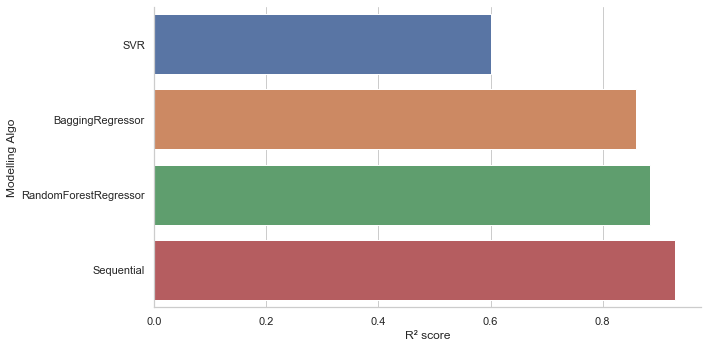

In [23]:
sns.factorplot(y='Modelling Algo',x='R² score',data=Output_df,kind='bar',size=5,aspect=2)

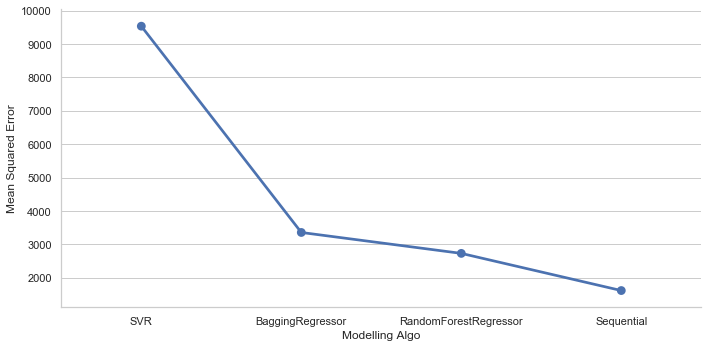

In [24]:
sns.factorplot(x='Modelling Algo',y='Mean Squared Error',data=Output_df,kind='point',size=5,aspect=2)

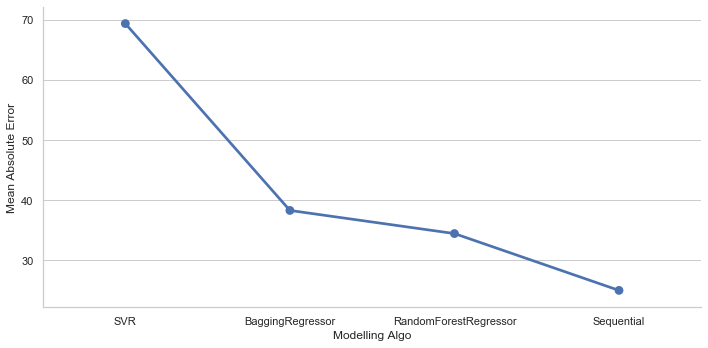

In [25]:
sns.factorplot(x='Modelling Algo',y='Mean Absolute Error',data=Output_df,kind='point',size=5,aspect=2)

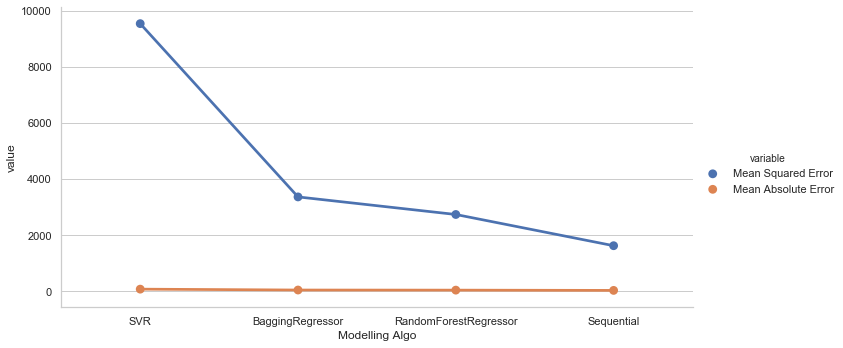

In [26]:
sns.factorplot(x='Modelling Algo', y='value', hue='variable', 
             data=pd.melt(Output_df.drop('R² score',axis=1), ['Modelling Algo']),size=5,aspect=2)

### Making Predictions

The best model selected is then used to make predictions on the test set. However, before prediction, necessary data preprocessing of the test set needs to be done. The feature engineering was done initially but the other preprocessing processes such as one-hot encoding, dropping unimportant features (based on the feature selection results on training set) and scaling have been done before making prediction using the ANN_model 

In [27]:
# Encoding the test set

encoded_data_dummy_test = test_df
def dummify_dataset(df, col):       
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col, drop_first=True)],axis=1)
    df = df.drop([col], axis=1)
    return df

columns_to_dummify = ['season', 'month', 'hour', 'holiday', 'day', 'workingday', 'weather','year']
for column in columns_to_dummify:
    encoded_data_dummy_test = dummify_dataset(encoded_data_dummy_test, column)
    
encoded_data_dummy_test.head(10)

# Dropping the unimportant features
test_df_full= encoded_data_dummy_test.drop(unimp_features, axis = 1).astype('float64')

# Converting test set to numpy array
X_test = test_df_full.values

# Scaling Test Set
scaler =  MinMaxScaler()
X_test = scaler.fit_transform(X_test) 


In [28]:
# Making Predictions using the best model ANN
y_pred = best_model.predict(X_test)
y_pred

array([[ 2.619448 ],
       [-1.4960115],
       [-2.291454 ],
       ...,
       [81.34196  ],
       [63.60688  ],
       [25.48902  ]], dtype=float32)

In [32]:
import csv
f  = open("predicted.csv", 'w')
writer = csv.writer(f)
for row in y_pred:
    writer.writerow(row)
f.close()